In [11]:
import numpy as np
import pandas as pd
import torch
import os

import matplotlib.pyplot as plt
from PIL import Image

import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split,Dataset
import torch.nn as nn
from torchsummary import summary

測試cuda是否可用

In [12]:
torch.cuda.is_available()

True

讀取training data 與 test data 、建立transform

In [13]:
train_path=r"C:/Users/MJ/Desktop/Music_Scale_Recognition/music_train"
test_path=r"C:/Users/MJ/Desktop/Music_Scale_Recognition/music_test"

transform=transforms.Compose([
    transforms.Resize((128,128)),     #將圖片大小縮放至(128*128)
    transforms.ToTensor()
])


建立Dataset class

In [14]:
class MusicDataset(Dataset):
    def __init__(self,root_dir,transform=None,is_train=True):

        super().__init__()
        self.train_truth=pd.read_csv("C:/Users/MJ/Desktop/Music_Scale_Recognition/train_truth.csv")
        self.root_dir=root_dir
        self.transform=transform
        self.is_train=is_train
        
        # 判斷是否為training data
        if (is_train):
            self.path=self.train_truth['filename']    #csv檔裡的圖片名稱
            
        else:
            self.path=os.listdir(root_dir)          #test data file 裡每個圖片檔案的檔名


    def __len__(self):
        return len(self.path)
    
    
    def __getitem__(self,idx):

        img_path = os.path.join(self.root_dir, self.path[idx])
        img = Image.open(img_path)
        
        img=self.transform(img)

        # 判斷是否為training data
        if (self.is_train):
            label=torch.tensor(int(self.train_truth['category'][idx]))
            return img,label
        
        else:
            return img

將data切成training data 和validation data，再將兩者與test data 裝成dataset

In [15]:
dataset=MusicDataset(train_path,transform,is_train=True)
trainset, validset = random_split(dataset, [0.9, 0.1])
train_size=len(trainset)
valid_size=len(validset)
testset=MusicDataset(test_path,transform,is_train=False)

將dataset裝進dataloader

In [16]:
train_dl=DataLoader(trainset,shuffle=True, batch_size=20)
valid_dl=DataLoader(validset,shuffle=True, batch_size=20)
test_dl=DataLoader(testset,shuffle=False, batch_size=20)

建立model class

In [17]:
class CNN(nn.Module):
    def __init__(self,in_channels=4,num_classes=88):
        super().__init__()

        self.features = nn.Sequential(                                                          #input=128*128
            nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=3,stride=1,padding=1), #(128-3+2*1)/1 +1=128   
            nn.MaxPool2d(kernel_size=2,stride=2),                                               #(128-2)/2 +1=64
            nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1,padding=1),          #(64-3+2*1)/1 +1=64
            nn.MaxPool2d(kernel_size=2,stride=2)                                                #(64-2)/2 +1=32
        )
                                                
        self.classifier = nn.Sequential(       
            nn.Linear(16*32*32, 128),                   
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

設定訓練的參數

In [18]:
epochs=10
model=CNN(4,88)
model=model.cuda()  #將模型放到gpu上
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
summary(model,(4,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             296
         MaxPool2d-2            [-1, 8, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]           1,168
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Linear-5                  [-1, 128]       2,097,280
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 88]          11,352
Total params: 2,110,096
Trainable params: 2,110,096
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 1.88
Params size (MB): 8.05
Estimated Total Size (MB): 10.18
----------------------------------------------------------------


train model和使用validation data評估model

In [20]:
train_losses = []
train_accu = []
val_losses=[]
val_accu = []

for epoch in range(epochs):
        model.train()
        train_loss=0
        accu=0
        ###################
        # train the model #
        ###################
        for data, target in train_dl:
                
                optim.zero_grad()
                data,target=data.cuda(),target.cuda()  #將data、target放到gpu上

                out = model(data)
                _, y_pred_tag = torch.max(out, dim = 1)  

                loss = criterion(out, target)
                loss.backward()
                
                optim.step()

                train_loss += loss.item()*data.size(0)  #loss.item is batch loss mean
                correct=torch.sum(y_pred_tag == target).item()  #sum 預測正確的次數
                accu += correct 
                

        train_loss=train_loss/train_size              # 1 epoch loss mean 
        accu=accu/train_size                          # 1 epoch accuracy mean
        train_losses.append(train_loss)
        train_accu.append(accu)


        ######################    
        # validate the model #
        ######################
        val_loss = 0
        accu = 0

        with torch.no_grad():
                model.eval()   

                for data, target in valid_dl:

                        data,target=data.cuda(),target.cuda()
                        out= model(data)
                        _, y_pred_tag = torch.max(out, dim = 1)
                        loss = criterion(out, target)

                        val_loss += loss.item()*data.size(0)
                        correct=torch.sum(y_pred_tag == target).item()
                        accu += correct      

                val_loss=val_loss/valid_size
                accu=accu/valid_size

                val_losses.append(val_loss)
                val_accu.append(accu)

                

將每個epoch的 Accuracy 和 Loss平均值畫出

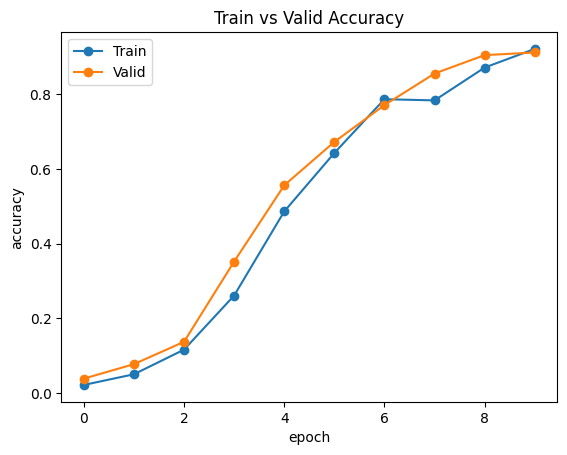

In [21]:
plt.plot(train_accu,'-o')
plt.plot(val_accu,'-o')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

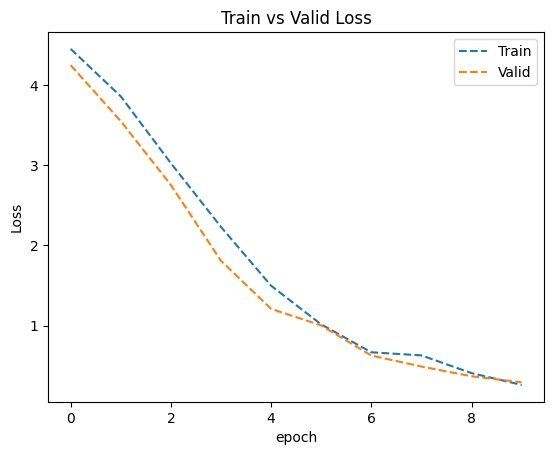

In [22]:
plt.plot(train_losses,'--')
plt.plot(val_losses,'--')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()

將test data丟進模型預測

In [23]:
model.eval()

output=[]
with torch.no_grad():
    for data in test_dl:
        data=data.cuda()
        out = model(data)
        _, y_pred_tag = torch.max(out, dim = 1)
        output.extend(y_pred_tag.cpu().numpy().tolist())


將預測結果寫成csv檔，並存起來

In [24]:
sample_submission=pd.read_csv(r"C:/Users/MJ/Desktop/Music_Scale_Recognition/sample_truth.csv")
sample_submission['category']=output
sample_submission.to_csv(r"C:/Users/MJ/Desktop/Music_Scale_Recognition/sample_truth.csv",index=False)